In [1]:
import data
import data_hf
from modelling import model
import jax.numpy as jnp
import jax
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

from importlib import reload
from tqdm import tqdm
model = reload(model)
import data
import data_hf
data = reload(data)
data_hf = reload(data_hf)
import data_shae
data_shae = reload(data_shae)
import finetune
finetune = reload(finetune)
import download_data
download_data = reload(download_data)

import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

2024-11-26 23:12:29.634806: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-26 23:12:29.641332: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-26 23:12:29.667371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-26 23:12:29.709056: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-26 23:12:29.721410: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 23:12:29.823518: I tensorflow/core/platform/cpu_feature_gu

In [2]:
cfg = model.Config(
    d_model=2048, # Hidden dim
    ffw_multiplier=4, # Multiplier for feedforward layer size
    query_heads=8, 
    key_heads=8,
    num_layers=12,
    key_dim=128,
    vocab_size=8,
    max_seq_len=8192,
    causal=True,
    use_attn_kernel=False,
    weight_dtype_at_rest=jnp.float32,
    active_weight_dtype=jnp.bfloat16,
    rules=model.mdl_parallel_rules,
    mesh=model.create_mesh(),
    max_lr=3e-5,
    min_lr=3e-6,
    warmup_steps=50,
    total_steps=10000,
)

# Checkpoint manager setup
checkpoint_dir = "gs://minformer_data/finetuned_ckpt_ip_sad/v1"
ckpt_manager = model.make_mngr(path=checkpoint_dir)
weights, opt_state = model.load(ckpt_manager, cfg) # Load model weights and optimizer state
start_step = ckpt_manager.latest_step() # Get the last checkpoint step

# JIT compilation is a performance optimization technique that converts the code into optimized machine learning code before it runs
# model.forward is the function that performs the forward pass through the model
# static_argnames=['cfg'] tells JAX that theh cfg argument won't change between calls (this allows additional optimizations since JAX knows this part stays constant
# Only the input data will change between runs
forward = jax.jit(model.forward, static_argnames=['cfg']) # JIT compile the forward pass for faster execution

# Update data iterator with new source
iter = data_shae.create_iterator([f"gs://minformer_data/go_data_ip_val/tfrecords/record_*.tfrecord"],
                                [],
                                batch_size=1,
                                shuffle=True)

I1126 23:14:25.576772 2057256 google_auth_provider.cc:181] Running on GCE, using service account 940527310713-compute@developer.gserviceaccount.com


In [3]:
# Get one batch to see the structure
cpu_batch = next(iter)
print("Available keys in the data:")
print(cpu_batch.keys())

# Print the shape and type of each field
for key in cpu_batch.keys():
    print(f"\nKey: {key}")
    print(f"Shape: {cpu_batch[key].shape if hasattr(cpu_batch[key], 'shape') else 'No shape'}")
    print(f"Type: {type(cpu_batch[key])}")
    # Print a sample value if possible
    try:
        print(f"Sample value: {cpu_batch[key][0]}")
    except:
        print("Could not print sample value")

Found 573 files for stage 1
Found 0 files for stage 2
Available keys in the data:
dict_keys(['x', 'segment_ids', 'lad_category', 'lad_value', 'sad_category', 'sad_value', 'chromosome', 'lad_conserved', 'sad_conserved', 'cell_type', 'start_pos', 'end_pos'])

Key: x
Shape: (1, 8192)
Type: <class 'numpy.ndarray'>
Sample value: [2 4 2 5 3 2 2 5 5 3 5 2 2 3 2 4 2 2 2 4 4 4 5 5 4 4 2 2 4 5 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Key: segment_ids
Shape: (1, 8192)
Type: <class 'numpy.ndarray'>
Sample value: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Key: lad_category
Shape: (1, 1)
Type: <class 'numpy.ndarray'>
Sample value: [1]

Key: lad_value
Shape: (1, 1)
Type: <class 'numpy.ndarray'>
Sample value: [1.05]

Key: sad_category
Shape: (1, 1)
Type: <class 'numpy.ndarray'>
Sample value: [0]

Key: sad_value
Shape: (1, 1)
Type: <class 'numpy.ndarray'>
Sample value: [0]

Key: chromosome
Shape

In [4]:
# Processes a batch of genomic data and makes prediction about LAD (Lamina-Associated Domains) and SPAD (Speckle-Associated Domains)
# Input: cpu_batch is a dictionary containing genomic sequence data and associated features
def get_row(cpu_batch):
    """Data extraction and conversion"""
    row = {
        # Convert sequence tokens back to original form
        "sequence": data_shae.detokenize(cpu_batch['x'][0]),
        "sequence_length": len(cpu_batch['x'][0]),
        
        # Use the reverse mappings
        # LAD properties
        # inner: cpu_batch['lad_category'][0][0]
            # cpu_batch['lad_category'] gets the LAD category data
            # [0] gets the first batch item
            # [0] gets the actual value from nested structure
        # data_shae.LAD_CAT_REV looks up reverse mapping e.g. 0: 'non_LAD', 1: 'weak-LAD' etc.
        # "lad_category": value adds the value to the row dictionary with key "lad_category"
        "lad_category": data_shae.LAD_CAT_REV[int(cpu_batch['lad_category'][0][0])], # Convert numeric category back to label
        "lad_value": float(cpu_batch['lad_value'][0][0]), # Numerical value
        "lad_conserved": bool(cpu_batch['lad_conserved'][0][0]), # Conservation status
        
        "sad_category": data_shae.SAD_CAT_REV[int(cpu_batch['sad_category'][0][0])],
        "sad_value": float(cpu_batch['sad_value'][0][0]),
        "sad_conserved": bool(cpu_batch['sad_conserved'][0]),
        
        "cell_type": data_shae.CELL_REV[int(cpu_batch['cell_type'][0][0])],
        "chromosome": cpu_batch['chromosome'][0][0].decode('utf-8'),

        # New genomic position information
        "start_pos": int(cpu_batch['start_pos'][0][0]),
        "end_pos": int(cpu_batch['end_pos'][0][0])
    }
    """Model processing and prediction"""
    # Prepare batch for model input
    batch = model.process_batch_shae(cpu_batch, cfg)
    # Run forward pass through the model
    # The _ syntax unpacks any othe returned values we don't need
    _, internals, _ = forward(
        batch['x'], # Input sequence
        batch['segment_ids'], # Segment identifiers
        weights, # Model weights
        cfg, # Model configuration
        aux=batch['aux']) # Additional info

    """Addition Predictions to Results"""
    # LAD predictions
    # The -1 refers to the axis along which to compute the maximum value, 01 refers to the last dimension of an array
    row['lad_pred'] = jnp.argmax(internals['lad_pred'], -1) # Predicted category
    row['lad_logits'] = jax.nn.softmax(internals['lad_pred'][0]) # Probability distribution
    row['sad_pred'] = jnp.argmax(internals['sad_pred'], -1) # Predicted category
    row['sad_logits'] = jax.nn.softmax(internals['sad_pred'][0]) # Probability distribution
    row['lad_value_pred'] = internals['lad_reg'] # Predicted value
    row['sad_value_pred'] = internals['sad_reg'] # Predicted 
    # Get embedding vector for the sequence
    row['embedding'] = np.array(internals['last_embed'][0, 0, :]) # Neural network embedding 

    return row

In [5]:
import sys

# Now let's load the data
print("\nLoading all samples...")
rows = []
# Create new iterator (with shuffle if desired)
iter = data_shae.create_iterator([f"gs://minformer_data/go_data_rg_val/tfrecords/record_*.tfrecord"],
                                [],
                                batch_size=1,
                                shuffle=True)

# Use the actual count instead of arbitrary 100000
for i in tqdm(range(30000)):
    try:
        cpu_batch = next(iter)
        cpu_row = get_row(cpu_batch)
        rows.append(cpu_row)
        
        # Optional: Print memory usage every 1000 samples to monitor
        if i > 0 and i % 1000 == 0:
            print(f"\nProcessed {i} samples")
            print(f"Current memory usage of rows: {len(rows) * sum(sys.getsizeof(row) for row in rows[:10]) / 10 / 1024 / 1024:.2f} MB")
            
    except Exception as e:
        print(f"Error processing batch {i}: {e}")
        continue

print(f"\nSuccessfully loaded {len(rows)} samples")


Loading all samples...


  0%|                                                                 | 0/30000 [00:00<?, ?it/s]

Found 573 files for stage 1
Found 0 files for stage 2


  3%|█▋                                                  | 1002/30000 [03:17<1:28:45,  5.45it/s]


Processed 1000 samples
Current memory usage of rows: 0.61 MB


  7%|███▍                                                | 2002/30000 [06:20<1:25:20,  5.47it/s]


Processed 2000 samples
Current memory usage of rows: 1.22 MB


 10%|█████▏                                              | 3002/30000 [09:24<1:22:16,  5.47it/s]


Processed 3000 samples
Current memory usage of rows: 1.83 MB


 13%|██████▉                                             | 4002/30000 [12:27<1:19:19,  5.46it/s]


Processed 4000 samples
Current memory usage of rows: 2.44 MB


 17%|████████▋                                           | 5002/30000 [15:30<1:16:09,  5.47it/s]


Processed 5000 samples
Current memory usage of rows: 3.05 MB


 20%|██████████▍                                         | 6002/30000 [18:33<1:13:09,  5.47it/s]


Processed 6000 samples
Current memory usage of rows: 3.66 MB


 23%|████████████▏                                       | 7002/30000 [21:36<1:10:11,  5.46it/s]


Processed 7000 samples
Current memory usage of rows: 4.27 MB


 27%|█████████████▊                                      | 8002/30000 [24:39<1:07:06,  5.46it/s]


Processed 8000 samples
Current memory usage of rows: 4.88 MB


 30%|███████████████▌                                    | 9002/30000 [27:42<1:04:05,  5.46it/s]


Processed 9000 samples
Current memory usage of rows: 5.49 MB


 33%|█████████████████                                  | 10002/30000 [30:45<1:00:59,  5.46it/s]


Processed 10000 samples
Current memory usage of rows: 6.10 MB


 37%|███████████████████▍                                 | 11002/30000 [33:48<57:51,  5.47it/s]


Processed 11000 samples
Current memory usage of rows: 6.71 MB


 40%|█████████████████████▏                               | 12002/30000 [36:51<54:50,  5.47it/s]


Processed 12000 samples
Current memory usage of rows: 7.32 MB


 43%|██████████████████████▉                              | 13002/30000 [39:54<52:04,  5.44it/s]


Processed 13000 samples
Current memory usage of rows: 7.94 MB


 47%|████████████████████████▋                            | 14002/30000 [42:57<48:48,  5.46it/s]


Processed 14000 samples
Current memory usage of rows: 8.55 MB


 50%|██████████████████████████▌                          | 15002/30000 [46:01<45:45,  5.46it/s]


Processed 15000 samples
Current memory usage of rows: 9.16 MB


 53%|████████████████████████████▎                        | 16002/30000 [49:04<42:55,  5.43it/s]


Processed 16000 samples
Current memory usage of rows: 9.77 MB


 57%|██████████████████████████████                       | 17002/30000 [52:07<39:44,  5.45it/s]


Processed 17000 samples
Current memory usage of rows: 10.38 MB


 60%|███████████████████████████████▊                     | 18002/30000 [55:10<36:48,  5.43it/s]


Processed 18000 samples
Current memory usage of rows: 10.99 MB


 63%|█████████████████████████████████▌                   | 19002/30000 [58:13<33:32,  5.46it/s]


Processed 19000 samples
Current memory usage of rows: 11.60 MB


 67%|██████████████████████████████████                 | 20002/30000 [1:01:16<30:31,  5.46it/s]


Processed 20000 samples
Current memory usage of rows: 12.21 MB


 70%|███████████████████████████████████▋               | 21002/30000 [1:04:19<27:26,  5.47it/s]


Processed 21000 samples
Current memory usage of rows: 12.82 MB


 73%|█████████████████████████████████████▍             | 22002/30000 [1:07:23<24:24,  5.46it/s]


Processed 22000 samples
Current memory usage of rows: 13.43 MB


 77%|███████████████████████████████████████            | 23002/30000 [1:10:26<21:21,  5.46it/s]


Processed 23000 samples
Current memory usage of rows: 14.04 MB


 80%|████████████████████████████████████████▊          | 24002/30000 [1:13:29<18:17,  5.46it/s]


Processed 24000 samples
Current memory usage of rows: 14.65 MB


 83%|██████████████████████████████████████████▌        | 25002/30000 [1:16:32<15:14,  5.46it/s]


Processed 25000 samples
Current memory usage of rows: 15.26 MB


 87%|████████████████████████████████████████████▏      | 26002/30000 [1:19:35<12:11,  5.47it/s]


Processed 26000 samples
Current memory usage of rows: 15.87 MB


 90%|█████████████████████████████████████████████▉     | 27002/30000 [1:22:38<09:11,  5.43it/s]


Processed 27000 samples
Current memory usage of rows: 16.48 MB


 93%|███████████████████████████████████████████████▌   | 28002/30000 [1:25:41<06:05,  5.46it/s]


Processed 28000 samples
Current memory usage of rows: 17.09 MB


 97%|█████████████████████████████████████████████████▎ | 29002/30000 [1:28:45<03:02,  5.46it/s]


Processed 29000 samples
Current memory usage of rows: 17.70 MB


100%|███████████████████████████████████████████████████| 30000/30000 [1:31:48<00:00,  5.45it/s]


Successfully loaded 30000 samples


In [6]:
df = pd.DataFrame(rows)


SPAD Conservation Analysis Summary:
Total SPADs: 7820
Correctly predicted SPADs: 2901 (37.1%)

Of correctly predicted SPADs:
Conserved: 0 (0.0%)
Non-conserved: 2901 (100.0%)

Of incorrectly predicted SPADs:
Conserved: 0
Non-conserved: 4919


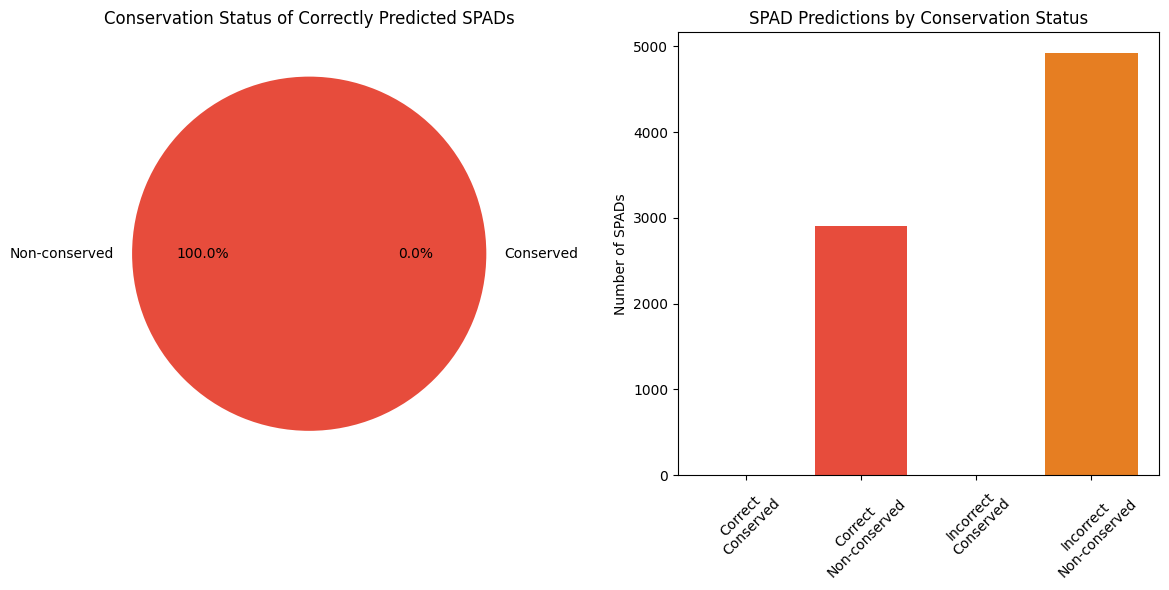

In [9]:
# First, let's prepare the data
def prepare_data(df):
    # Convert JAX array predictions to integers
    df = df.copy()  # Create a copy to avoid modifying the original
    
    # Convert predictions to integers
    df['sad_pred_int'] = df['sad_pred'].apply(lambda x: int(x[0]))
    
    # Create category mappings
    sad_categories = {'inter-SAD': 0, 'SAD': 1, 'SAD boundary': 2}
    
    # Convert categories to indices
    df['sad_category_idx'] = df['sad_category'].map(sad_categories)
    
    return df

def analyze_sad_conservation_predictions(df):
    # Prepare the data first
    df = prepare_data(df)
    
    # Create mask for correct LAD predictions
    correct_predictions = df['sad_pred_int'] == df['sad_category_idx']
    
    # Analyze LADs specifically (where lad_category is 'LAD')
    sad_mask = df['sad_category'] == 'SAD'
    
    # Different groups for analysis
    correctly_predicted_sads = sad_mask & correct_predictions
    incorrectly_predicted_sads = sad_mask & ~correct_predictions
    
    # Calculate proportions
    total_sads = sad_mask.sum()
    correct_sads = correctly_predicted_sads.sum()
    
    # Conservation analysis for correct LAD predictions
    conserved_correct_sads = (df[correctly_predicted_sads]['sad_conserved']).sum()
    non_conserved_correct_sads = correct_sads - conserved_correct_sads
    
    # Conservation analysis for incorrect LAD predictions
    conserved_incorrect_sads = (df[incorrectly_predicted_sads]['sad_conserved']).sum()
    non_conserved_incorrect_sads = incorrectly_predicted_sads.sum() - conserved_incorrect_sads
    
    # Calculate percentages
    pct_correct_conserved = (conserved_correct_sads / correct_sads * 100) if correct_sads > 0 else 0
    pct_correct_non_conserved = (non_conserved_correct_sads / correct_sads * 100) if correct_sads > 0 else 0
    
    # Create summary dict
    results = {
        'total_sads': total_sads,
        'correct_predictions': correct_sads,
        'correct_conserved': conserved_correct_sads,
        'correct_non_conserved': non_conserved_correct_sads,
        'incorrect_conserved': conserved_incorrect_sads,
        'incorrect_non_conserved': non_conserved_incorrect_sads,
        'pct_correct_conserved': pct_correct_conserved,
        'pct_correct_non_conserved': pct_correct_non_conserved
    }
    
    return results

def plot_conservation_analysis(results):
    plt.figure(figsize=(12, 6))
    
    # Plot 1: Correct Predictions Breakdown
    plt.subplot(1, 2, 1)
    labels = ['Conserved', 'Non-conserved']
    sizes = [results['correct_conserved'], results['correct_non_conserved']]
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'])
    plt.title('Conservation Status of Correctly Predicted SPADs')
    
    # Plot 2: All LAD Predictions by Conservation
    plt.subplot(1, 2, 2)
    categories = ['Correct\nConserved', 'Correct\nNon-conserved', 
                 'Incorrect\nConserved', 'Incorrect\nNon-conserved']
    values = [results['correct_conserved'], results['correct_non_conserved'],
             results['incorrect_conserved'], results['incorrect_non_conserved']]
    
    plt.bar(categories, values, color=['#2ecc71', '#e74c3c', '#3498db', '#e67e22'])
    plt.xticks(rotation=45)
    plt.title('SPAD Predictions by Conservation Status')
    plt.ylabel('Number of SPADs')
    
    plt.tight_layout()
    plt.show()

# Run the analysis
results = analyze_sad_conservation_predictions(df)

# Print the summary statistics
print("\nSPAD Conservation Analysis Summary:")
print(f"Total SPADs: {results['total_sads']}")
print(f"Correctly predicted SPADs: {results['correct_predictions']} ({results['correct_predictions']/results['total_sads']*100:.1f}%)")
print("\nOf correctly predicted SPADs:")
print(f"Conserved: {results['correct_conserved']} ({results['pct_correct_conserved']:.1f}%)")
print(f"Non-conserved: {results['correct_non_conserved']} ({results['pct_correct_non_conserved']:.1f}%)")
print("\nOf incorrectly predicted SPADs:")
print(f"Conserved: {results['incorrect_conserved']}")
print(f"Non-conserved: {results['incorrect_non_conserved']}")

# Plot the results
plot_conservation_analysis(results)

Preparing data for UMAP...
Extracting embeddings...
Computing UMAP projection...


/home/shaemclaughlin/minformer/.venv/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP data preparation complete.
Creating visualization plots...


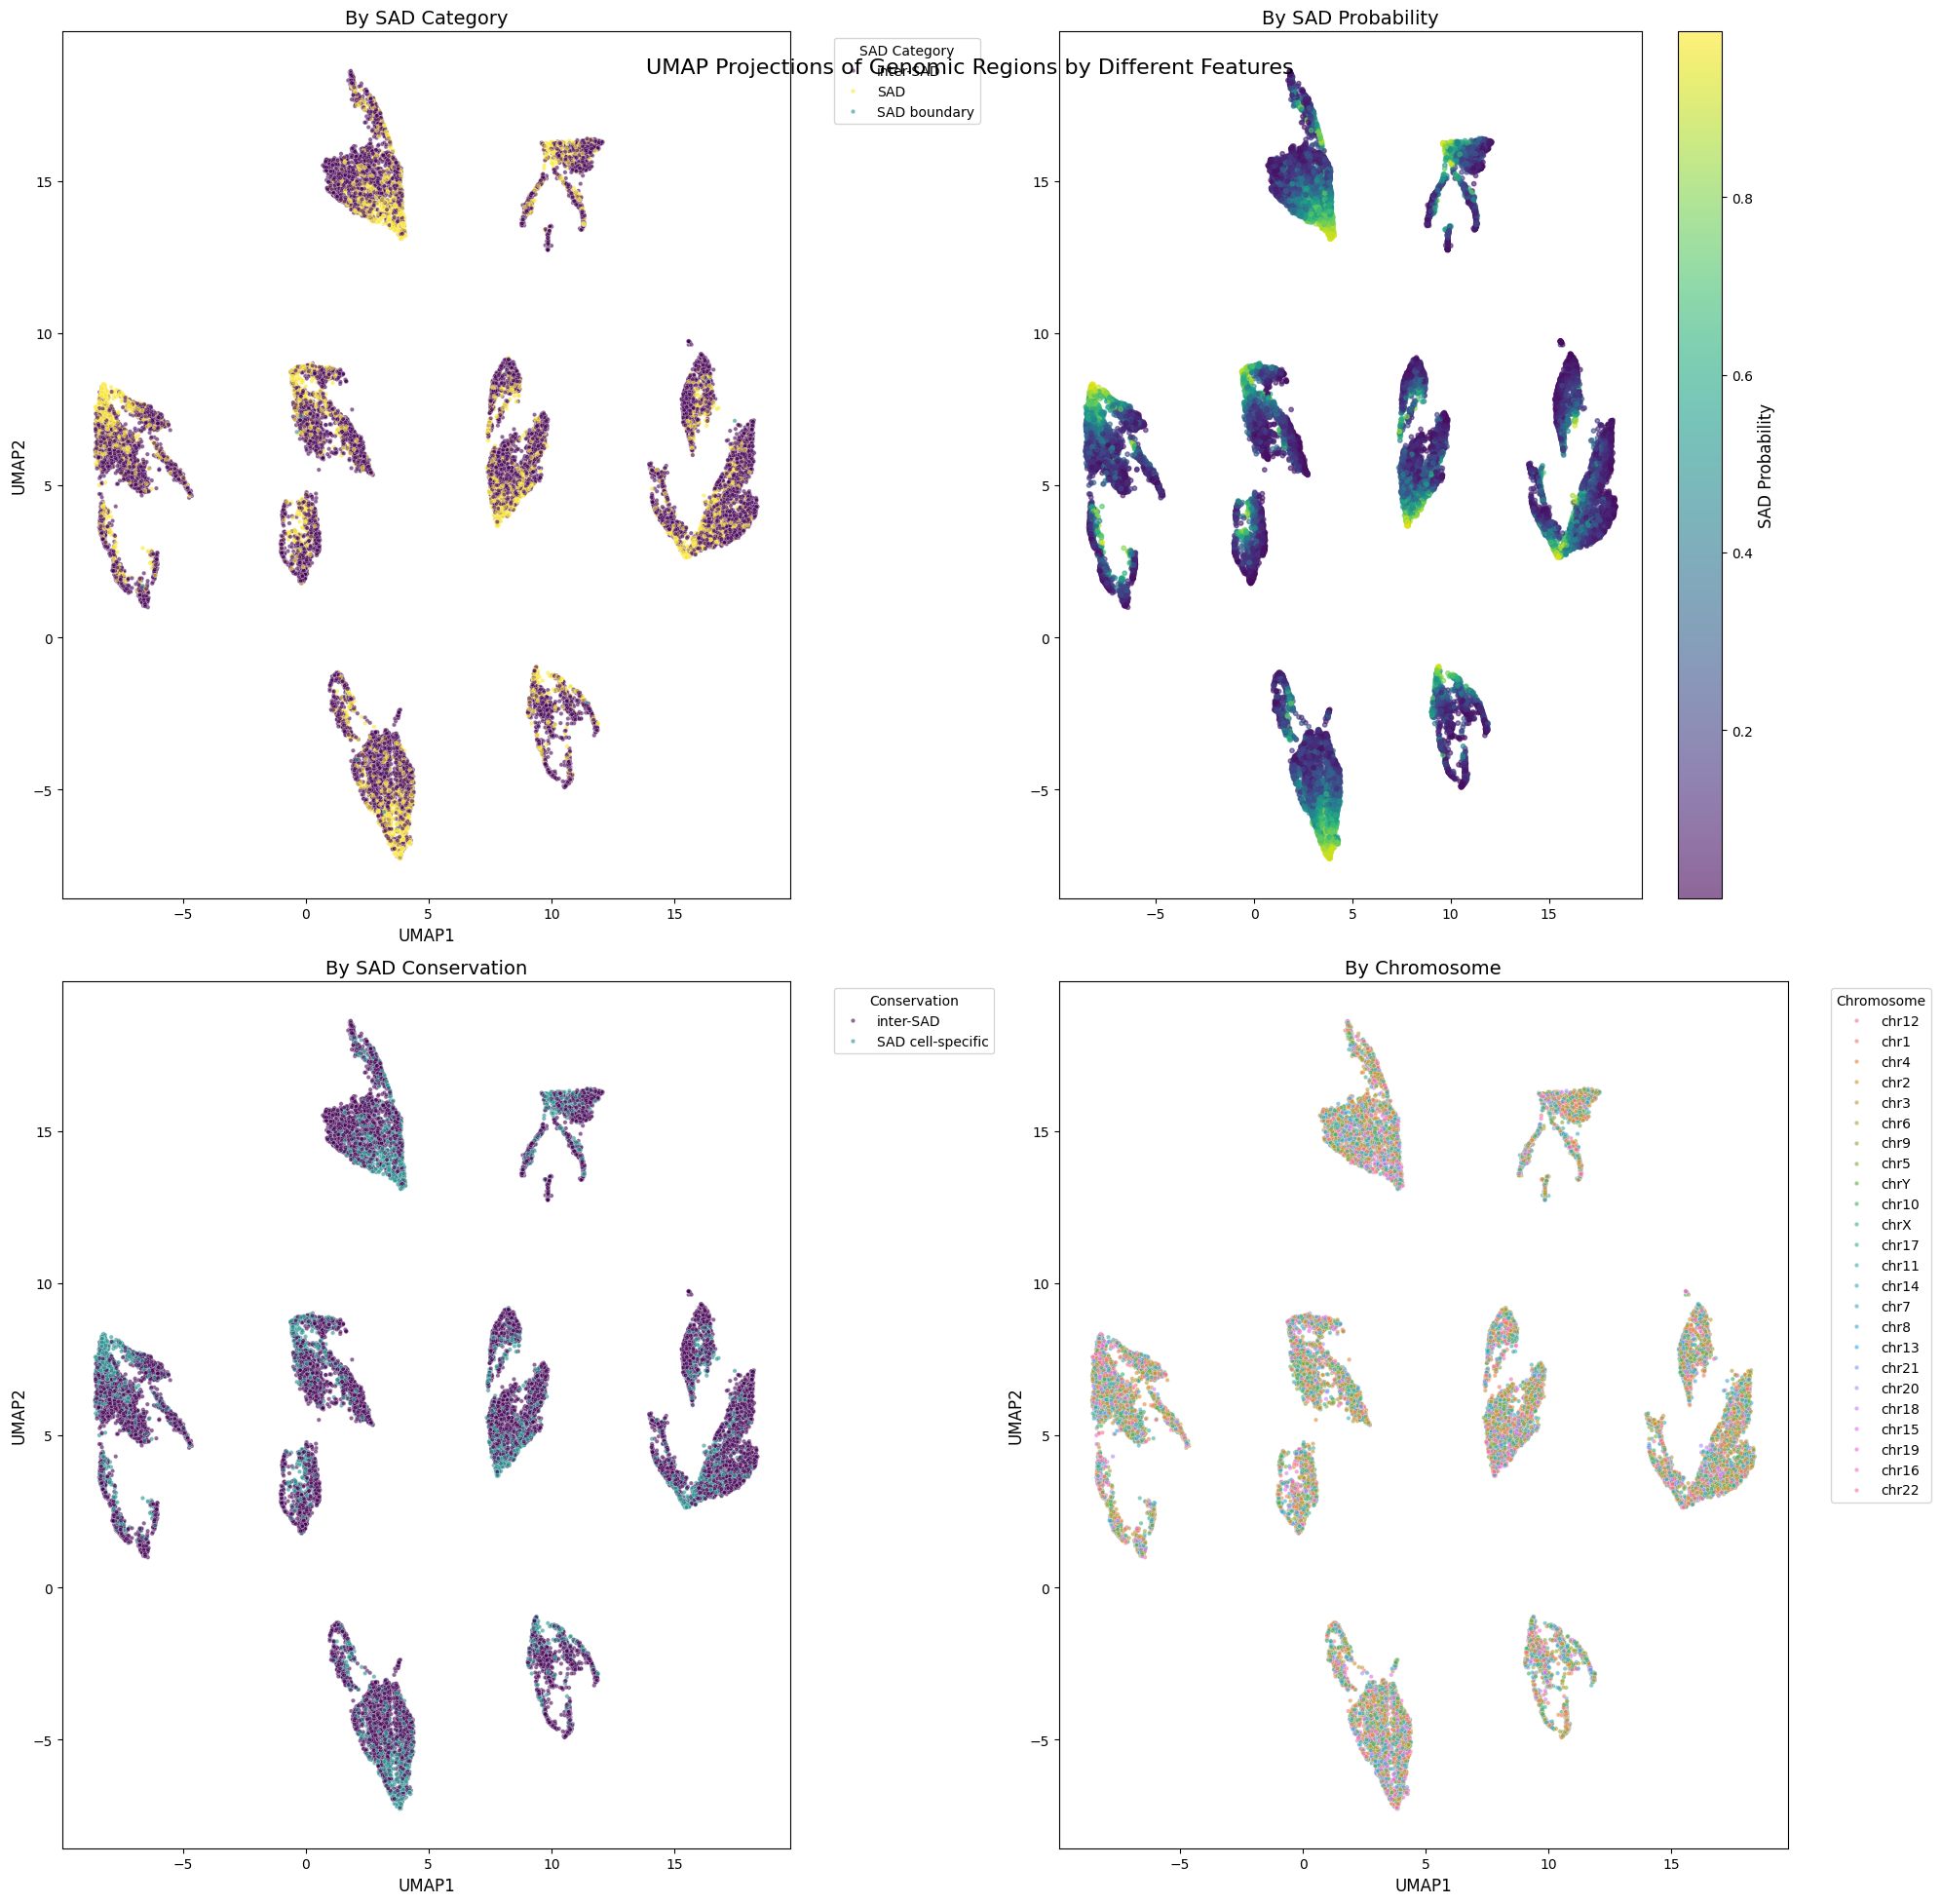


Summary Statistics:

SPAD Category Distribution:
SAD Category
inter-SAD       73.7
SAD             26.1
SAD boundary     0.2
Name: proportion, dtype: float64

SPAD Conservation Distribution:
SAD Conservation
inter-SAD            73.7
SAD cell-specific    26.3
Name: proportion, dtype: float64

SPAD Probability Statistics:
count    30000.000
mean         0.261
std          0.208
min          0.011
25%          0.109
50%          0.188
75%          0.343
max          0.986
Name: SAD Probability, dtype: float64


In [10]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from typing import Any

def prepare_data_for_umap(df):
    # Create copy of dataframe
    df = df.copy()
    
    # Extract embeddings
    print("Extracting embeddings...")
    embeddings = np.stack(df['embedding'].values)
    
    # Compute UMAP projection
    print("Computing UMAP projection...")
    reducer = umap.UMAP(random_state=42, n_jobs=-1)
    umap_coords = reducer.fit_transform(embeddings)
    
    # Create LAD Conservation status that includes all three categories
    def get_conservation_status(row):
        if row['sad_category'] == 'inter-SAD':
            return 'inter-SAD'
        elif row['sad_conserved']:
            return 'SAD conserved'
        else:
            return 'SAD cell-specific'
    
    # Create plot dataframe with all features
    plot_df = pd.DataFrame({
        'UMAP1': umap_coords[:, 0],
        'UMAP2': umap_coords[:, 1],
        'SAD Category': df['sad_category'],
        'SAD Probability': df['sad_logits'].apply(lambda x: float(x[1])),  # Probability of being LAD
        'SAD Conservation': df.apply(get_conservation_status, axis=1),
        'Chromosome': df['chromosome']
    })
    
    return plot_df

def create_umap_plots(plot_df):
    # Set figure style
    plt.rcParams.update({
        'figure.figsize': (20, 20),
        'axes.labelsize': 12,
        'axes.titlesize': 14,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10
    })
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2)
    fig.suptitle('UMAP Projections of Genomic Regions by Different Features', fontsize=16, y=0.95)
    
    # Define colors from viridis palette
    dark_purple = '#440154'  # Dark purple for inter-LAD
    yellow = '#fde725'      # Yellow for LAD/conserved
    green = '#20908c'       # Green for boundary/cell-specific
    
    # Custom color palettes
    sad_category_colors = {
        'SAD': yellow,
        'inter-SAD': dark_purple,
        'SAD boundary': green
    }
    
    conservation_colors = {
        'SAD conserved': yellow,
        'SAD cell-specific': green,
        'inter-SAD': dark_purple
    }
    
    # LAD Category plot
    sns.scatterplot(data=plot_df, 
                    x='UMAP1', 
                    y='UMAP2', 
                    hue='SAD Category',
                    palette=sad_category_colors,
                    alpha=0.6,
                    s=10,
                    ax=axes[0,0])
    axes[0,0].set_title('By SAD Category')
    axes[0,0].legend(title='SAD Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # LAD Probability plot
    scatter = axes[0,1].scatter(plot_df['UMAP1'], 
                               plot_df['UMAP2'],
                               c=plot_df['SAD Probability'],
                               cmap='viridis',
                               alpha=0.6,
                               s=10)
    axes[0,1].set_title('By SAD Probability')
    fig.colorbar(scatter, ax=axes[0,1], label='SAD Probability')
    
    # Conservation plot
    sns.scatterplot(data=plot_df, 
                    x='UMAP1', 
                    y='UMAP2', 
                    hue='SAD Conservation',
                    palette=conservation_colors,
                    alpha=0.6,
                    s=10,
                    ax=axes[1,0])
    axes[1,0].set_title('By SAD Conservation')
    axes[1,0].legend(title='Conservation', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Chromosome plot
    sns.scatterplot(data=plot_df, 
                    x='UMAP1', 
                    y='UMAP2', 
                    hue='Chromosome',
                    alpha=0.6,
                    s=10,
                    ax=axes[1,1])
    axes[1,1].set_title('By Chromosome')
    axes[1,1].legend(title='Chromosome', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()



# Run the analysis
print("Preparing data for UMAP...")
plot_df = prepare_data_for_umap(df)
print("UMAP data preparation complete.")

# Create plots
print("Creating visualization plots...")
create_umap_plots(plot_df)
#create_detailed_probability_plot(plot_df)

# Print summary statistics
print("\nSummary Statistics:")
print("\nSPAD Category Distribution:")
print(plot_df['SAD Category'].value_counts(normalize=True).round(3) * 100)

print("\nSPAD Conservation Distribution:")
print(plot_df['SAD Conservation'].value_counts(normalize=True).round(3) * 100)

print("\nSPAD Probability Statistics:")
print(plot_df['SAD Probability'].describe().round(3))

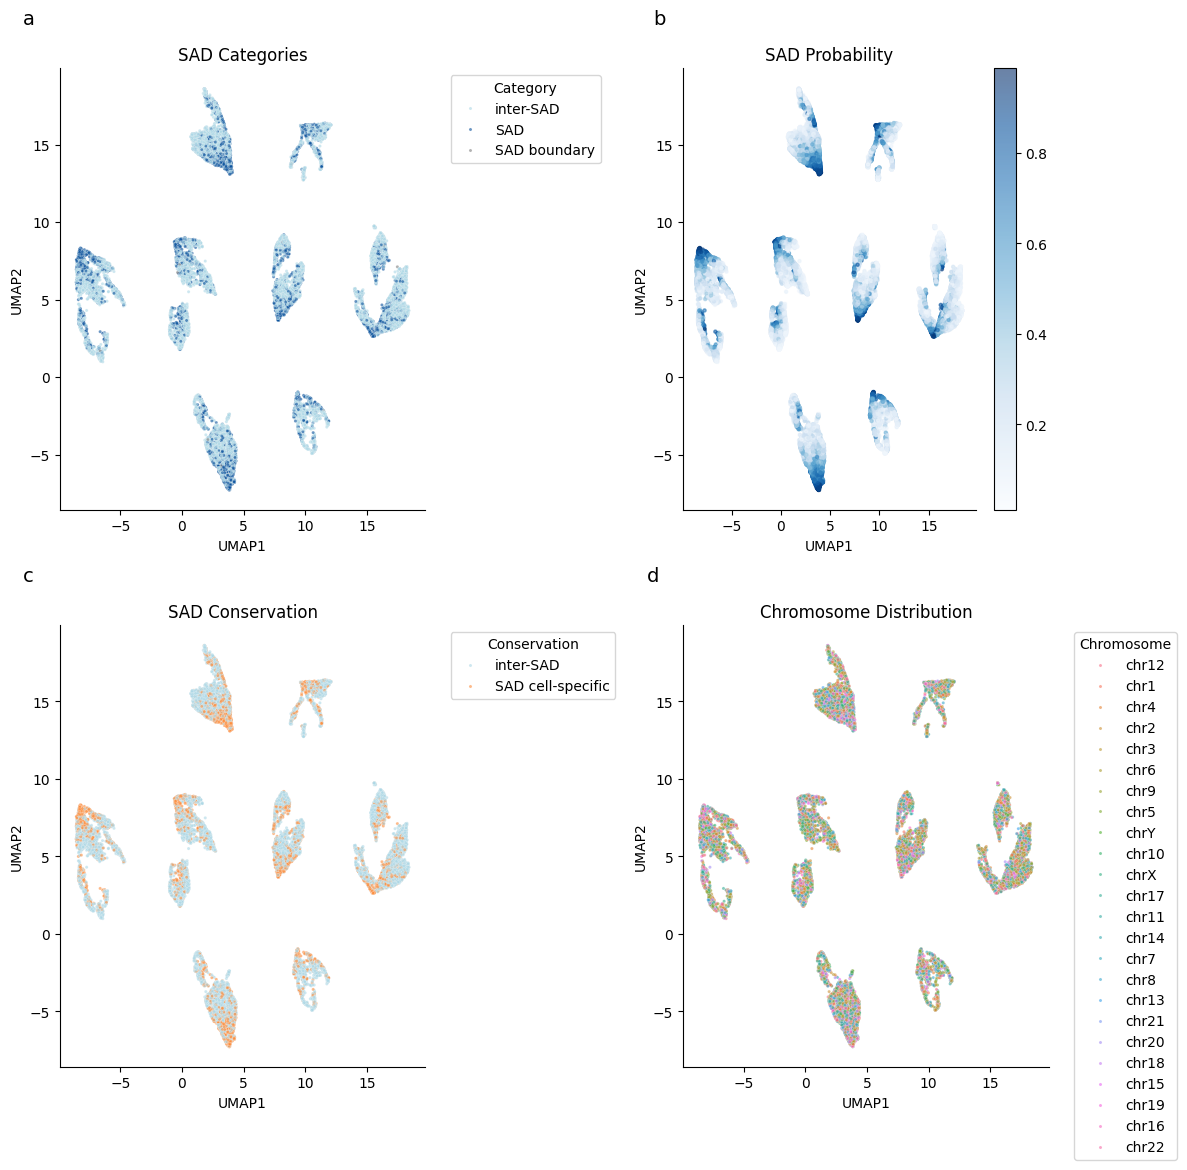

In [11]:
def create_umap_plots(plot_df):
    # Set figure style
    plt.style.use('default')  # Reset style
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    # Colors - ensure LAD blue matches probability >0.8 from Blues colormap
    sad_blue = '#08519c'     # This should match the >0.8 color from Blues colormap
    light_blue = '#ADD8E6'   # Light blue for inter-LADs
    cell_specific_orange = '#fd8d3c'  # Orange for cell-specific LADs
    boundary_color = '#808080'  # Grey for boundaries
    
    # Custom color palettes
    sad_category_colors = {
        'SAD': sad_blue,
        'inter-SAD': light_blue,
        'SAD boundary': boundary_color
    }
    
    conservation_colors = {
        'SAD conserved': sad_blue,
        'SAD cell-specific': cell_specific_orange,
        'inter-SAD': light_blue  # Same light blue as LAD categories
    }
    
    # Panel a: LAD Category plot
    sns.scatterplot(data=plot_df, 
                   x='UMAP1', 
                   y='UMAP2', 
                   hue='SAD Category',
                   palette=sad_category_colors,
                   alpha=0.6,
                   s=5,
                   ax=axes[0,0])
    axes[0,0].set_title('SAD Categories', fontsize=12)
    axes[0,0].legend(title='Category', bbox_to_anchor=(1.05, 1))
    
    # Panel b: LAD Probability plot
    scatter = axes[0,1].scatter(plot_df['UMAP1'], 
                              plot_df['UMAP2'],
                              c=plot_df['SAD Probability'],
                              cmap='Blues',
                              alpha=0.6,
                              s=5)
    axes[0,1].set_title('SAD Probability', fontsize=12)
    fig.colorbar(scatter, ax=axes[0,1])
    
    # Panel c: Conservation plot
    sns.scatterplot(data=plot_df, 
                   x='UMAP1', 
                   y='UMAP2', 
                   hue='SAD Conservation',
                   palette=conservation_colors,
                   alpha=0.6,
                   s=5,
                   ax=axes[1,0])
    axes[1,0].set_title('SAD Conservation', fontsize=12)
    axes[1,0].legend(title='Conservation', bbox_to_anchor=(1.05, 1))
    
    # Panel d: Chromosome plot
    sns.scatterplot(data=plot_df, 
                   x='UMAP1', 
                   y='UMAP2', 
                   hue='Chromosome',
                   alpha=0.6,
                   s=5,
                   ax=axes[1,1])
    axes[1,1].set_title('Chromosome Distribution', fontsize=12)
    axes[1,1].legend(title='Chromosome', bbox_to_anchor=(1.05, 1))
    
    # Add panel labels - removed bold
    for i, ax in enumerate(axes.flat):
        ax.text(-0.1, 1.1, chr(97+i), transform=ax.transAxes, 
                fontsize=14, fontweight='normal')
        ax.set_xlabel('UMAP1')
        ax.set_ylabel('UMAP2')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    return fig

# Create and save figure
fig = create_umap_plots(plot_df)
fig.savefig('umap_analysis.pdf', bbox_inches='tight', dpi=300)
plt.show()

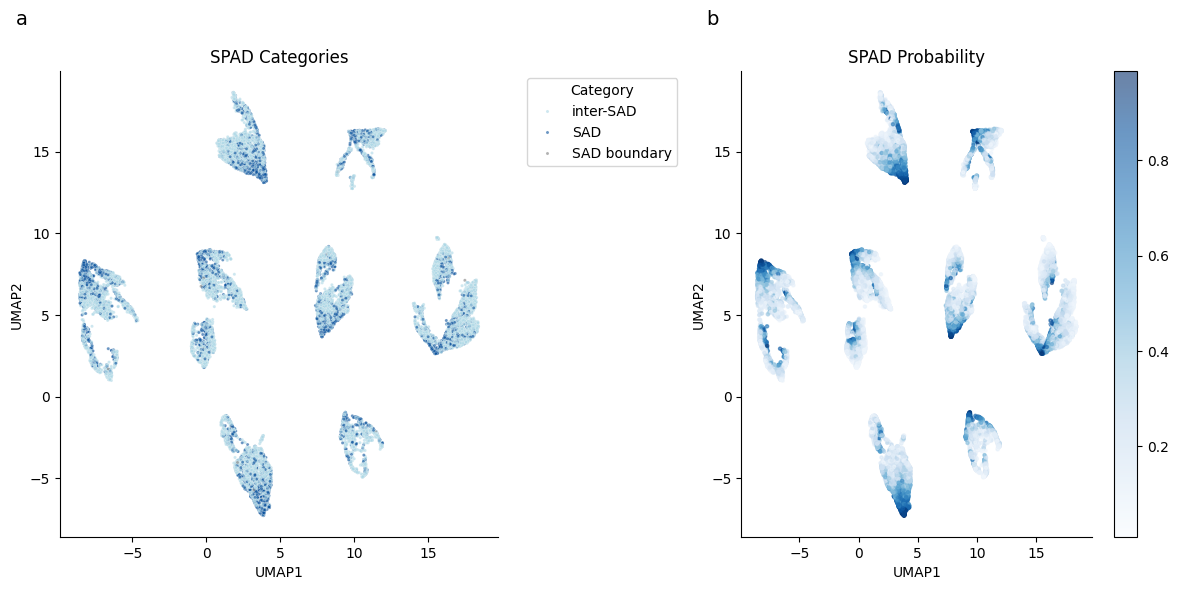

In [12]:
def create_umap_plots(plot_df):
    # Set figure style
    plt.style.use('default')  # Reset style
    
    # Create figure with subplots - now 1x2 instead of 2x2
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Colors - ensure LAD blue matches probability >0.8 from Blues colormap
    sad_blue = '#08519c'     # This should match the >0.8 color from Blues colormap
    light_blue = '#ADD8E6'   # Light blue for inter-LADs
    boundary_color = '#808080'  # Grey for boundaries
    
    # Custom color palette
    sad_category_colors = {
        'SAD': sad_blue,
        'inter-SAD': light_blue,
        'SAD boundary': boundary_color
    }
    
    # Panel a: Category plot
    sns.scatterplot(data=plot_df, 
                   x='UMAP1', 
                   y='UMAP2', 
                   hue='SAD Category',
                   palette=sad_category_colors,
                   alpha=0.6,
                   s=5,
                   ax=axes[0])
    
    # Modify legend labels to show SPAD instead of SAD
    legend = axes[0].get_legend()
    new_labels = [t.get_text().replace('SAD', 'SPAD') for t in legend.get_texts()]
    for t, new_text in zip(legend.get_texts(), new_labels):
        t.set_text(new_text)
    
    axes[0].set_title('SPAD Categories', fontsize=12)
    axes[0].legend(title='Category', bbox_to_anchor=(1.05, 1))
    
    # Panel b: Probability plot
    scatter = axes[1].scatter(plot_df['UMAP1'], 
                            plot_df['UMAP2'],
                            c=plot_df['SAD Probability'],
                            cmap='Blues',
                            alpha=0.6,
                            s=5)
    axes[1].set_title('SPAD Probability', fontsize=12)
    fig.colorbar(scatter, ax=axes[1])
    
    # Add panel labels - removed bold
    for i, ax in enumerate(axes.flat):
        ax.text(-0.1, 1.1, chr(97+i), transform=ax.transAxes, 
                fontsize=14, fontweight='normal')
        ax.set_xlabel('UMAP1')
        ax.set_ylabel('UMAP2')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    return fig

# Create and save figure
fig = create_umap_plots(plot_df)
fig.savefig('umap_analysis.pdf', bbox_inches='tight', dpi=300)
plt.show()

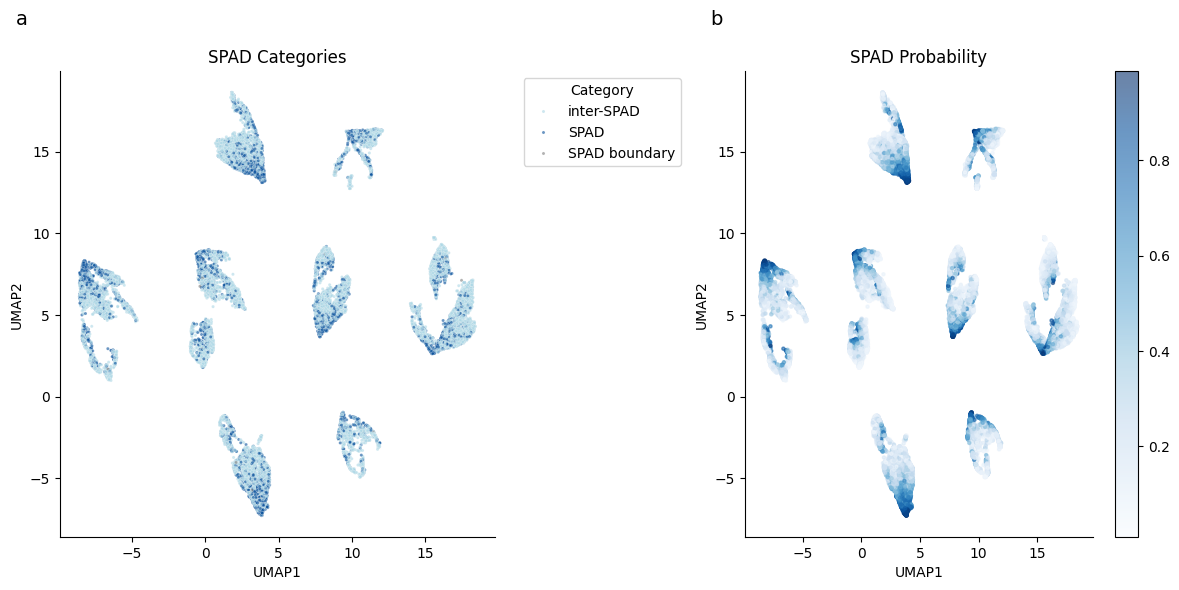

In [13]:
def create_umap_plots(plot_df):
    # Set figure style
    plt.style.use('default')  # Reset style
    
    # Create figure with subplots - now 1x2 instead of 2x2
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Colors - ensure LAD blue matches probability >0.8 from Blues colormap
    sad_blue = '#08519c'     # This should match the >0.8 color from Blues colormap
    light_blue = '#ADD8E6'   # Light blue for inter-LADs
    boundary_color = '#808080'  # Grey for boundaries
    
    # Custom color palette with SPAD labels for legend
    sad_category_colors = {
        'SAD': sad_blue,
        'inter-SAD': light_blue,
        'SAD boundary': boundary_color
    }
    
    # Create a mapping for legend labels
    label_map = {
        'SAD': 'SPAD',
        'inter-SAD': 'inter-SPAD',
        'SAD boundary': 'SPAD boundary'
    }
    
    # Panel a: Category plot
    scatter = sns.scatterplot(data=plot_df, 
                            x='UMAP1', 
                            y='UMAP2', 
                            hue='SAD Category',
                            palette=sad_category_colors,
                            alpha=0.6,
                            s=5,
                            ax=axes[0])
    
    # Update legend labels
    handles = scatter.get_legend_handles_labels()[0]
    labels = scatter.get_legend_handles_labels()[1]
    new_labels = [label_map[l] for l in labels]
    axes[0].legend(handles, new_labels, title='Category', bbox_to_anchor=(1.05, 1))
    
    axes[0].set_title('SPAD Categories', fontsize=12)
    
    # Panel b: Probability plot
    scatter = axes[1].scatter(plot_df['UMAP1'], 
                            plot_df['UMAP2'],
                            c=plot_df['SAD Probability'],
                            cmap='Blues',
                            alpha=0.6,
                            s=5)
    axes[1].set_title('SPAD Probability', fontsize=12)
    fig.colorbar(scatter, ax=axes[1])
    
    # Add panel labels - removed bold
    for i, ax in enumerate(axes.flat):
        ax.text(-0.1, 1.1, chr(97+i), transform=ax.transAxes, 
                fontsize=14, fontweight='normal')
        ax.set_xlabel('UMAP1')
        ax.set_ylabel('UMAP2')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    return fig

# Create and save figure
fig = create_umap_plots(plot_df)
fig.savefig('umap_analysis.pdf', bbox_inches='tight', dpi=300)
plt.show()